#**Runtime: [T4 GPU]**
The NVIDIA Tesla T4 is a graphics processing unit (GPU).

Optimized for mainstream computing environments,including tasks like image recognition, natural language processing.



#1.Introduction


##Definition
Image captioning is the process of automatically generating a textual description of an image. It bridges the gap between computer vision and natural language processing (NLP).

##Real-Time Applications
**1.Social Media Accessibility:**Social media platforms can automatically generate captions for images, making them more accessible for everyone.

**2.Image Search Improvement:** Image captioning can be used to improve image search by allowing users to search for images based on their content, not just keywords in filenames or captions.

**3.Real-time Scene Understanding:** Self-driving cars and robots can use image captioning to understand their surroundings and make decisions based on the visual information.

**4.Automatic Image Annotation:** Image captioning can be used to automatically tag images with relevant keywords, making them easier to organize and find.

##Flickr8k Dataset
The **Flickr8k dataset** is a popular benchmark dataset for image captioning research. It consists of:

**8,000 images:** Sourced from Flickr with a variety of content (people, landscapes, objects, etc.)

**Captions:** Each image has 5 human-written captions describing the content.
The dataset is used to train and evaluate image captioning models. Researchers can compare the generated captions by their models with the human-written captions to assess the model's performance.

#2.Importing Libraries

In [ ]:
import glob
import pandas as pd
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image, ImageFont, ImageDraw
import seaborn as sns
from pickle import dump, load
import time
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, \
    Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D, Input, Bidirectional
from keras.optimizers import Adam, RMSprop
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

#3.Downloading the dataset through Kaggle
Since Flickr8k dataset is of size 1.03 GB, this approach lets us access the dataset without downloading it local system or drive.

##3.1 Downloading the kaggle package

In [ ]:
!pip install kaggle

##3.2 Uploading the kaggle API Key

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##3.3 Dataset Kaggle Command

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:04<00:00, 157MB/s]
100% 1.04G/1.04G [00:04<00:00, 231MB/s]


##3.4 Dataset Successfully downloaded into Colab Environment

In [ ]:
!unzip flickr8k.zip

#4.Understanding the Data

##4.1 Images in the Dataset

In [ ]:
images='/content/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
all_imgs=all_imgs[:15000]
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


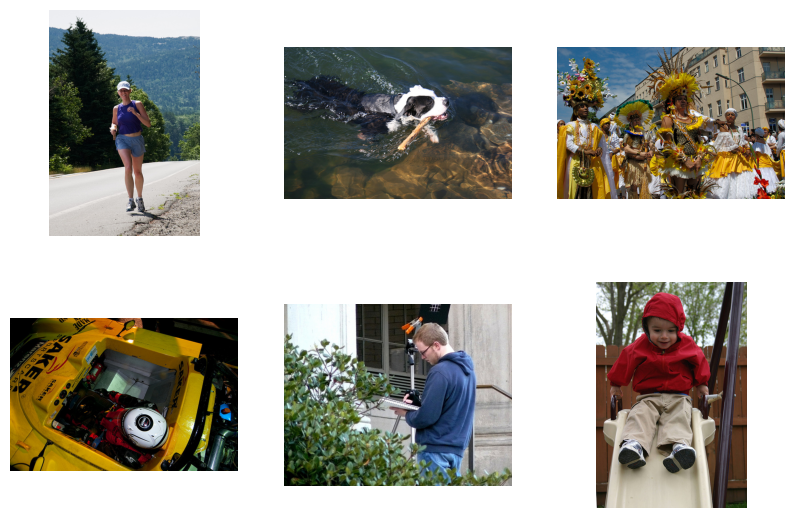

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(6):
    img_path = all_imgs[i]
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

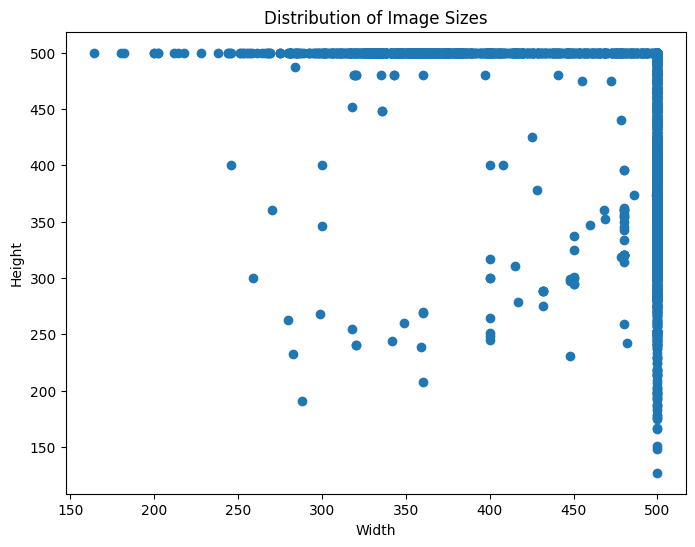

In [ ]:
image_sizes = []
for img_path in all_imgs:
    img = Image.open(img_path)
    image_sizes.append(img.size)

# Plot distribution of image sizes
plt.figure(figsize=(8, 6))
plt.scatter(*zip(*image_sizes))
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes')
plt.show()

In [ ]:
all_imgs[10]

'/content/Images/3285993030_87b0f1d202.jpg'

##4.2 Captions in the Dataset

In [ ]:
def load_doc(filename):

    text=open(filename).read()

    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)
    return keys,values,key_paths

text_file="/content/captions.txt"
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


##4.3 Mapping Images and Captions

In [ ]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)#store all the image id here
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df


ID                                       Path  \
0      1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   /content/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   /content/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   /content/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   /content/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   /content/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

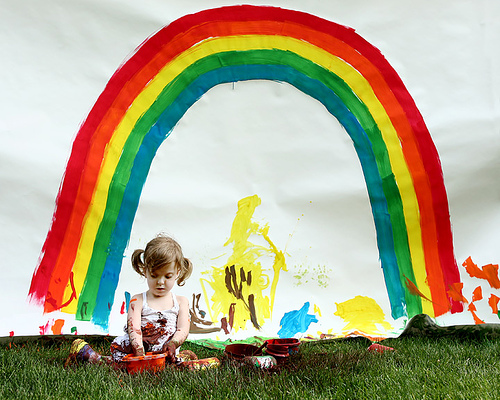

In [ ]:
Image.open(all_img_vector[10])

#5.Exploaratory Data Analysis (EDA)

In [ ]:
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

##5.1 Plot-1: Frequency of Words in Captions

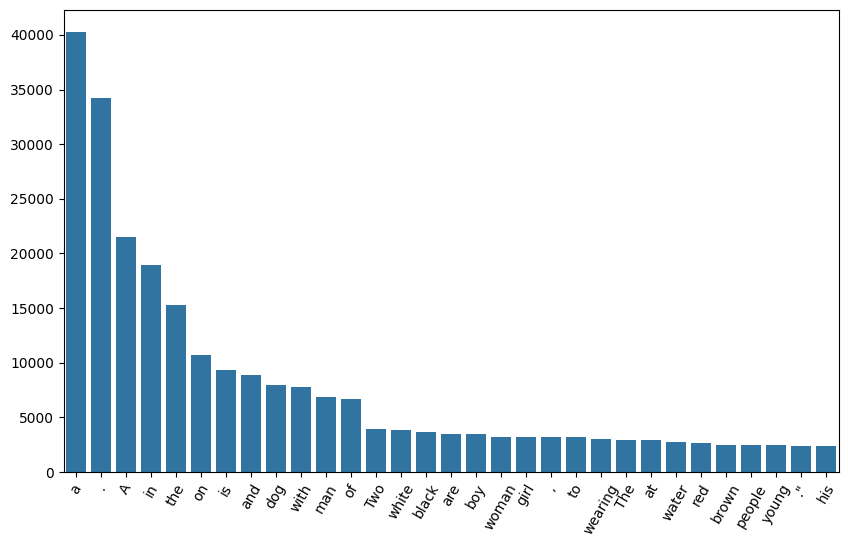

In [ ]:
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

In [ ]:
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


##5.2 Plot-2: Images and Captions

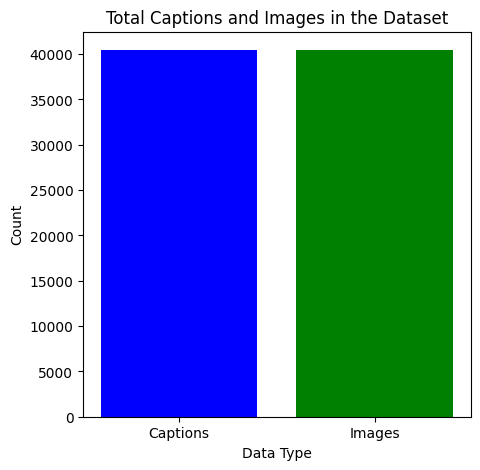

In [ ]:
# Plot total number of captions and images
plt.figure(figsize=(5, 5))
plt.bar(['Captions', 'Images'], [len(annotations), len(all_img_path)], color=['blue', 'green'])
plt.title('Total Captions and Images in the Dataset')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.show()

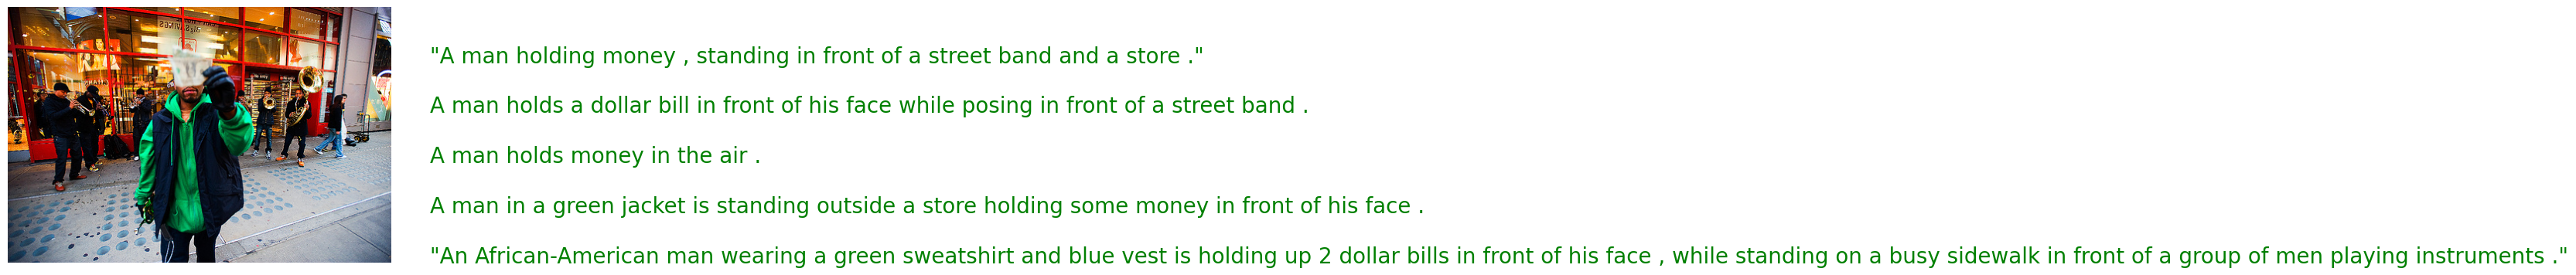

In [ ]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='green')
caption_and_image_plotter(df.ID.iloc[8049],df)

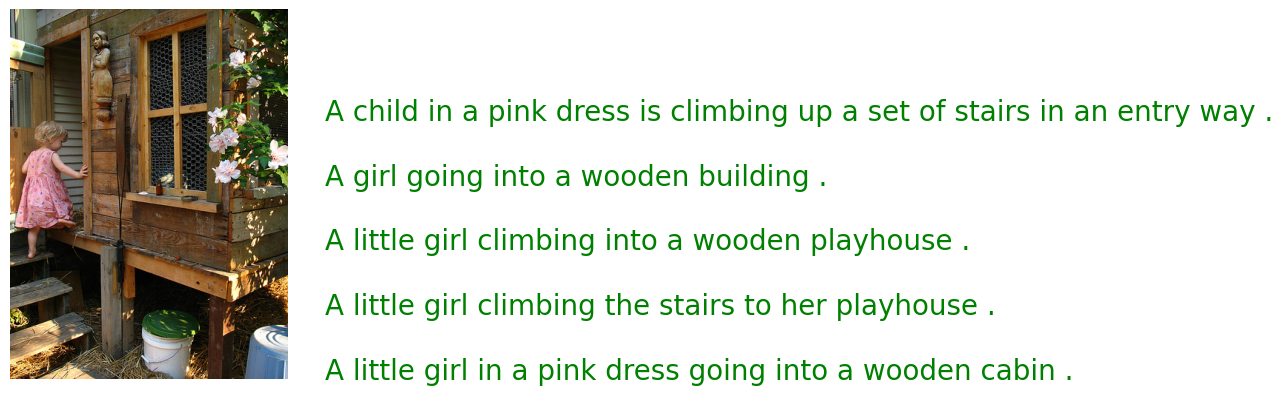

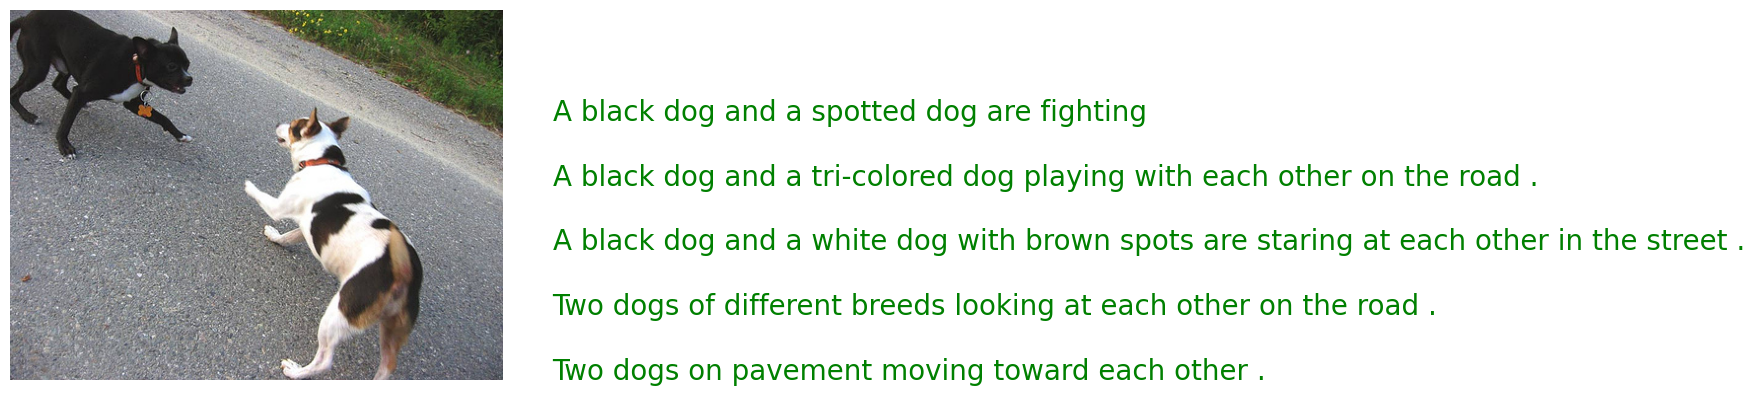

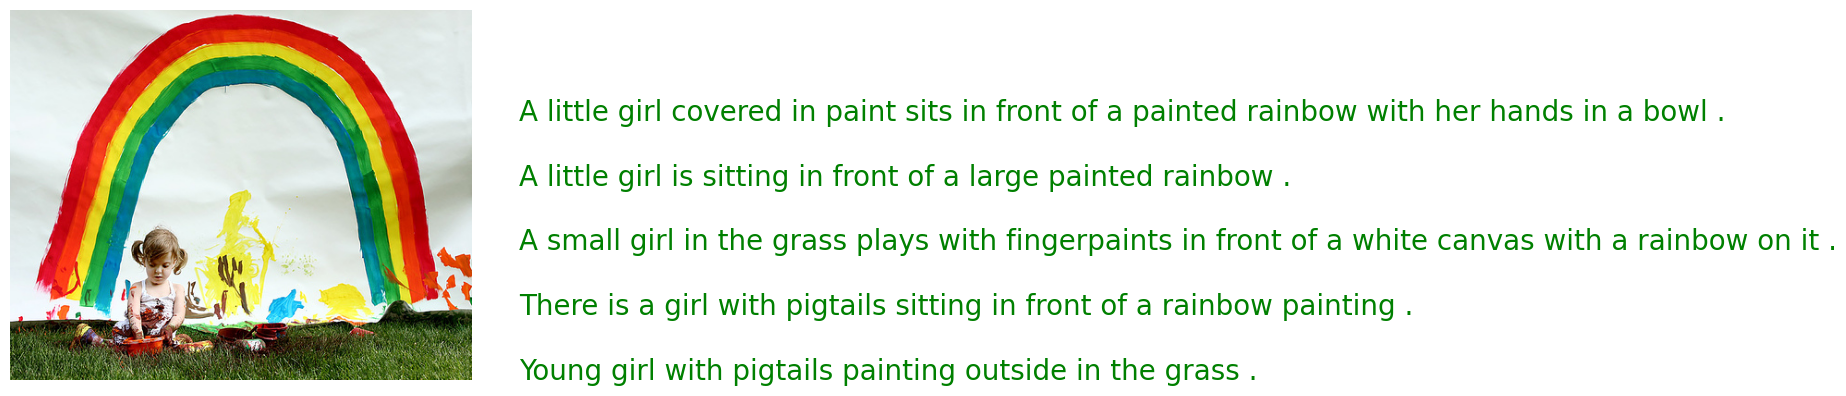

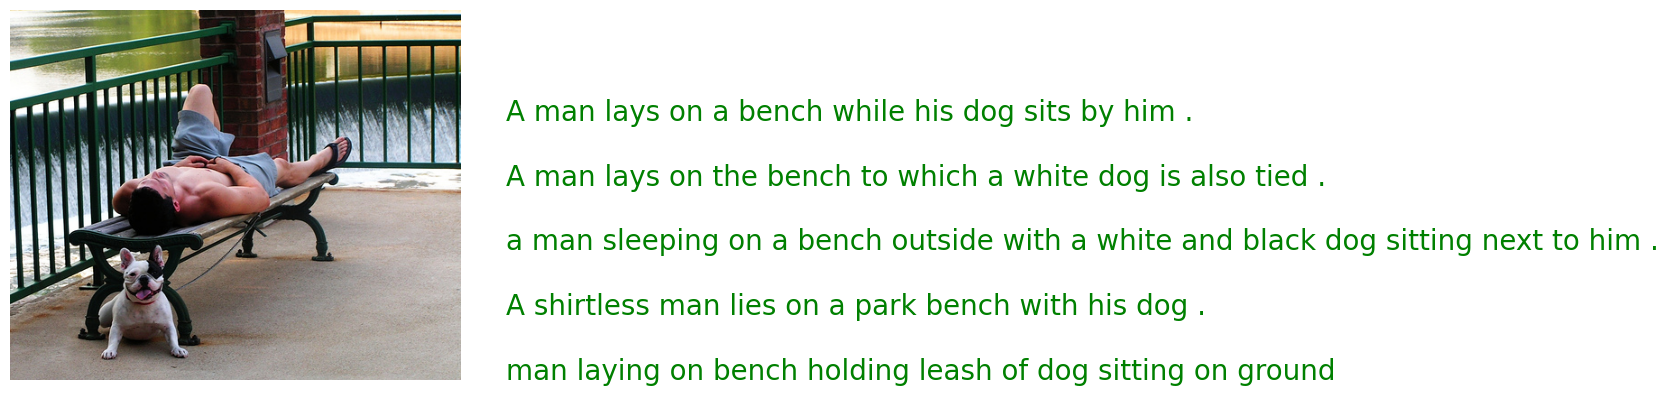

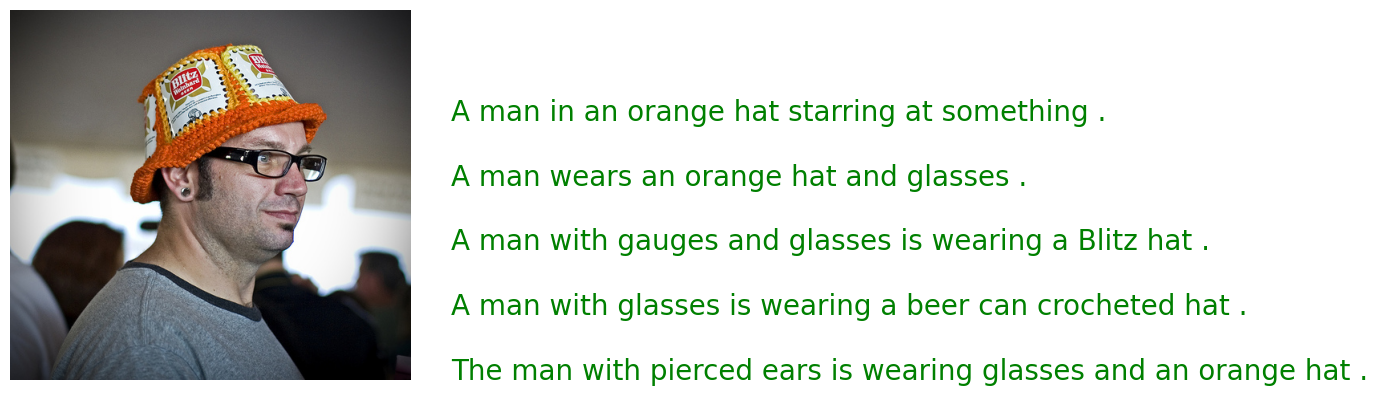

In [ ]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,5,df)

In [ ]:
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

##5.3 Plot-3:Distribution of word counts in the captions

 Provides insights into the lengths of the captions and their frequency in the dataset

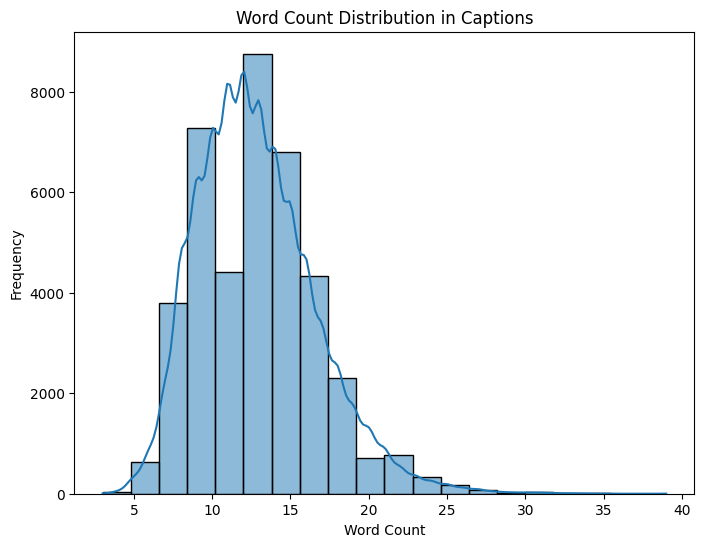

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

word_counts = [len(seq) for seq in train_seqs]

# Plot word count distribution in sequences
plt.figure(figsize=(8, 6))
sns.histplot(word_counts, bins=20, kde=True)
plt.title('Word Count Distribution in Captions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

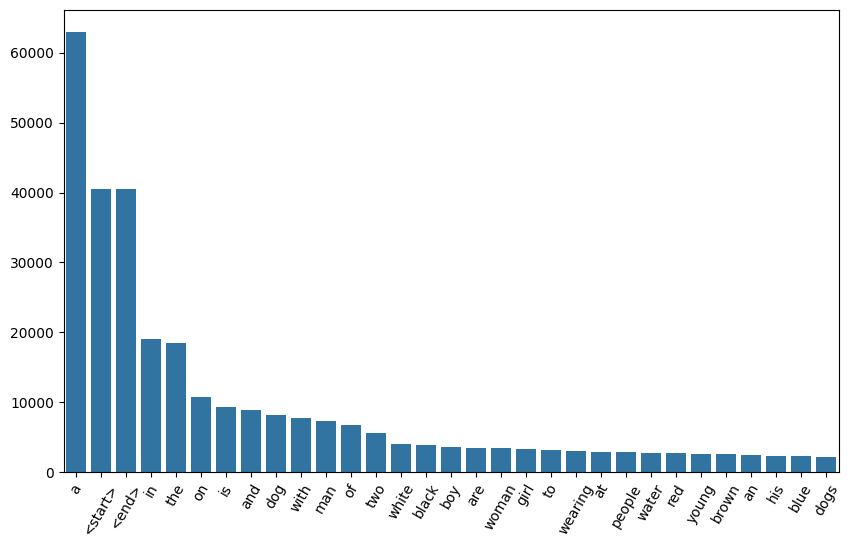

In [ ]:
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [ ]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_seqs)

In [ ]:
cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l) #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [ ]:
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

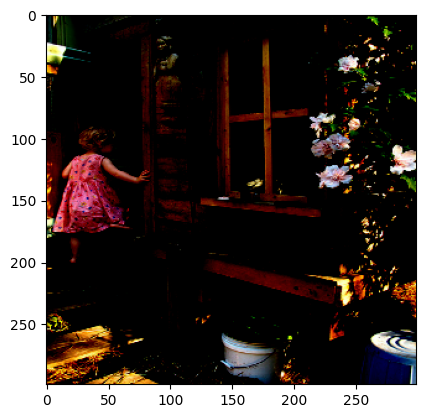

In [ ]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [ ]:
encode_train_set = sorted(set(all_img_vector))
feature_dict = {}
image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [ ]:
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

#6.Train-Test Split

In [ ]:
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [ ]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


##6.1 Plot-4: Train(Data,Captions) vs Test(Data,Captions)

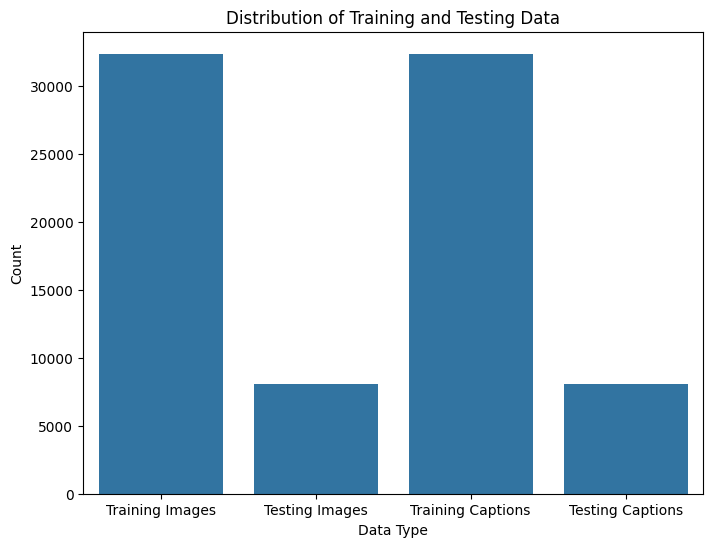

In [ ]:
data_types = ['Training Images', 'Testing Images', 'Training Captions', 'Testing Captions']
data_counts = [len(image_train), len(image_test), len(caption_train), len(caption_test)]

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=data_types, y=data_counts)
plt.title('Distribution of Training and Testing Data')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.show()


In [ ]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

#7.Transfer Learning (InceptionV3)

##7.1 InceptionV3:
**InceptionV3** is a convolutional neural network (CNN) architecture specifically designed for image recognition and classification. It's part of the Inception family of architectures developed by Google researchers.

**Key Features:**

1.Deep Architecture

2.Inception Modules

3.Auxillary Classifiers

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


##7.2 Model Summary

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

#8.Feature Extraction

In [ ]:
from tqdm import tqdm

In [ ]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [02:21<00:00,  1.78it/s]


In [ ]:
batch_f.shape

TensorShape([64, 2048])

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):

    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [ ]:
for batch_images, batch_captions in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(batch_images[i])
        plt.title(batch_captions[i].numpy().decode("utf-8"))
        plt.axis('off')
    plt.show()

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


In [ ]:
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

#9.Sequence-to-Sequence Model
**Seq2Seq (sequence-to-sequence)** models are a type of neural network architecture specifically designed for tasks that involve transforming sequences from one domain to another.

**Basic Structure:**

1.Encoder

2.Decoder

##9.1 Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)

    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

##9.2 Attention Model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

##9.3 RNN Decoder

In [ ]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

##9.4 Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x))
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

#10.Optimizers, Loss Function, Checkpoints

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/File4/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

#11.Model Training and Testing

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('GPU IS UP')
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.193, & test loss is 1.012
Time taken for 1 epoch 290.35489106178284 sec

Test loss has been reduced from 100.000 to 1.012


  7%|▋         | 1/15 [04:50<1:07:50, 290.77s/it]

For epoch: 2, the train loss is 0.938, & test loss is 0.899
Time taken for 1 epoch 118.06736397743225 sec

Test loss has been reduced from 1.012 to 0.899


 13%|█▎        | 2/15 [06:49<41:01, 189.31s/it]  

For epoch: 3, the train loss is 0.854, & test loss is 0.829
Time taken for 1 epoch 116.85504078865051 sec

Test loss has been reduced from 0.899 to 0.829


 20%|██        | 3/15 [08:46<31:16, 156.34s/it]

For epoch: 4, the train loss is 0.792, & test loss is 0.774
Time taken for 1 epoch 115.93647265434265 sec

Test loss has been reduced from 0.829 to 0.774


 27%|██▋       | 4/15 [10:42<25:45, 140.48s/it]

For epoch: 5, the train loss is 0.741, & test loss is 0.725
Time taken for 1 epoch 113.22655391693115 sec

Test loss has been reduced from 0.774 to 0.725


 33%|███▎      | 5/15 [12:35<21:47, 130.78s/it]

For epoch: 6, the train loss is 0.698, & test loss is 0.684
Time taken for 1 epoch 114.19948363304138 sec

Test loss has been reduced from 0.725 to 0.684


 40%|████      | 6/15 [14:30<18:47, 125.23s/it]

For epoch: 7, the train loss is 0.657, & test loss is 0.644
Time taken for 1 epoch 113.43963479995728 sec

Test loss has been reduced from 0.684 to 0.644


 47%|████▋     | 7/15 [16:24<16:11, 121.46s/it]

For epoch: 8, the train loss is 0.621, & test loss is 0.611
Time taken for 1 epoch 114.15482926368713 sec

Test loss has been reduced from 0.644 to 0.611


 53%|█████▎    | 8/15 [18:18<13:54, 119.26s/it]

For epoch: 9, the train loss is 0.587, & test loss is 0.577
Time taken for 1 epoch 112.55277609825134 sec

Test loss has been reduced from 0.611 to 0.577


 60%|██████    | 9/15 [20:11<11:43, 117.24s/it]

For epoch: 10, the train loss is 0.558, & test loss is 0.548
Time taken for 1 epoch 114.61254096031189 sec

Test loss has been reduced from 0.577 to 0.548


 67%|██████▋   | 10/15 [22:06<09:42, 116.50s/it]

For epoch: 11, the train loss is 0.529, & test loss is 0.520
Time taken for 1 epoch 115.33243751525879 sec

Test loss has been reduced from 0.548 to 0.520


 73%|███████▎  | 11/15 [24:01<07:45, 116.26s/it]

For epoch: 12, the train loss is 0.504, & test loss is 0.497
Time taken for 1 epoch 114.13952827453613 sec

Test loss has been reduced from 0.520 to 0.497


 80%|████████  | 12/15 [25:56<05:47, 115.69s/it]

For epoch: 13, the train loss is 0.481, & test loss is 0.474
Time taken for 1 epoch 116.7961778640747 sec

Test loss has been reduced from 0.497 to 0.474


 87%|████████▋ | 13/15 [27:53<03:52, 116.10s/it]

For epoch: 14, the train loss is 0.460, & test loss is 0.454
Time taken for 1 epoch 113.82419490814209 sec

Test loss has been reduced from 0.474 to 0.454


 93%|█████████▎| 14/15 [29:47<01:55, 115.52s/it]

For epoch: 15, the train loss is 0.441, & test loss is 0.434
Time taken for 1 epoch 114.61772036552429 sec

Test loss has been reduced from 0.454 to 0.434


100%|██████████| 15/15 [31:42<00:00, 126.84s/it]


##11.1 Plot-5: Train vs Test Loss Plot

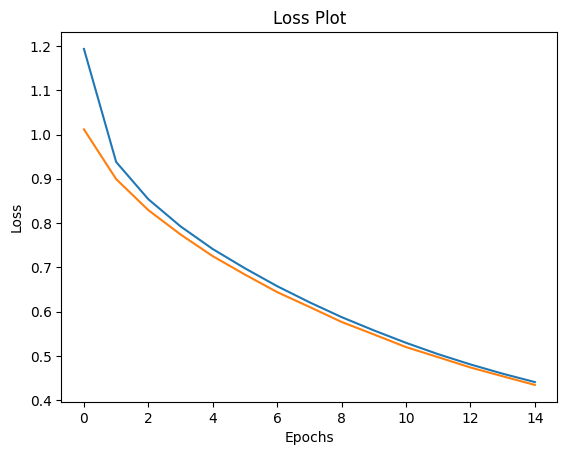

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

##11.2 Model Evaluation

In [ ]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

#12.Caption to Audio

In [ ]:
!pip install gTTs

##12.1 Predicted Captions and Generation of Audio File

Prediction Caption: a dog is running through a field of green grass


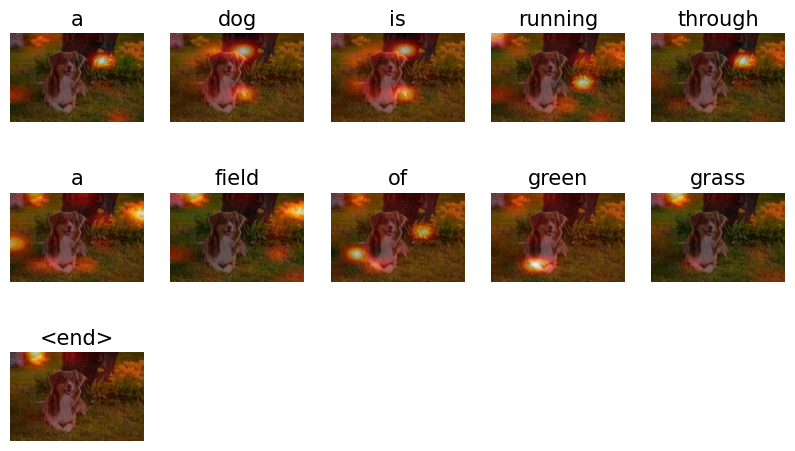

In [ ]:
from gtts import gTTS
import numpy as np

# Define a function to generate and save the audio file
def save_audio(text, filename):
    tts = gTTS(text=text, lang='en')
    tts.save(filename)

# Example usage:
rid = np.random.randint(0, len(image_test))
test_image = '/content/test.jpeg'
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)

#real_caption = filt_text(real_caption)
pred_caption = ' '.join(result).rsplit(' ', 1)[0]
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)
# Generate and save audio for pred_caption
save_audio(pred_caption, 'pred_caption.mp3')
